<a target="_blank" href="https://colab.research.google.com/github/lukebarousse/Python_Data_Analytics_Course/blob/main/3_Project/2_Skill_Demand.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final findings


## Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
!pip install --upgrade datasets fsspec
# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Filter Data for Germany

Filter the data for the market of Germany

In [2]:
df_Germany = df[df['job_country'] == 'Germany']

## Explode Skills

Converts the `job_skills` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the `job_title` and `job_skills` columns, allowing us to analyze the distribution of skills across different data job titles.

In [3]:
df_skills = df_Germany.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",python
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",sql
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",c#
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",azure
2,"Data Engineer/Scientist/Analyst, Mid or Senior...",airflow
...,...,...
785735,Senior Data Engineer,docker
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sas
785737,CRM Data Analyst,sql


## Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
907,python,Data Scientist,4157
906,python,Data Engineer,3524
1139,sql,Data Engineer,3145
1138,sql,Data Analyst,2947
905,python,Data Analyst,2309
...,...,...,...
1369,yarn,Data Analyst,1
1371,yarn,Data Scientist,1
1375,zoom,Data Engineer,1
792,outlook,Cloud Engineer,1


## Create List of Top 3 Roles

#### Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

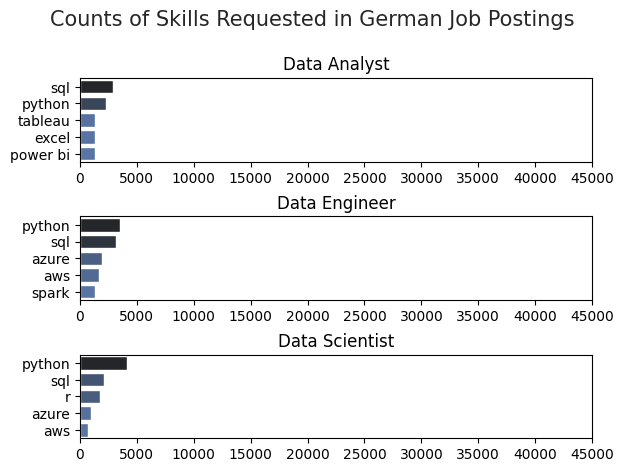

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in German Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages

#### Focus: Counts don't show what portions of jobs are requesting these skills

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the `value_counts()` method on the `job_title_short` column. Then reset the index to transform the Series into a DataFrame and renames the columns to `job_title_short` and `total`. The DataFrame `df_job_title_count` now holds a list of job titles alongside their total occurrences.

In [7]:
# Use original df to get the count of job titles
df_job_title_count = df_Germany['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,7131
1,Data Scientist,6745
2,Data Engineer,6675
3,Senior Data Engineer,2041
4,Senior Data Scientist,1737
5,Senior Data Analyst,1216
6,Business Analyst,817
7,Software Engineer,741
8,Machine Learning Engineer,402
9,Cloud Engineer,189


Then we calculate the percentages. First merge `df_skills_count` and `df_job_title_count`, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [8]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,4157,6745,61.630838
1,python,Data Engineer,3524,6675,52.794007
2,sql,Data Engineer,3145,6675,47.116105
3,sql,Data Analyst,2947,7131,41.326602
4,python,Data Analyst,2309,7131,32.379750
...,...,...,...,...,...
1377,yarn,Data Analyst,1,7131,0.014023
1378,yarn,Data Scientist,1,6745,0.014826
1379,zoom,Data Engineer,1,6675,0.014981
1380,outlook,Cloud Engineer,1,189,0.529101


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

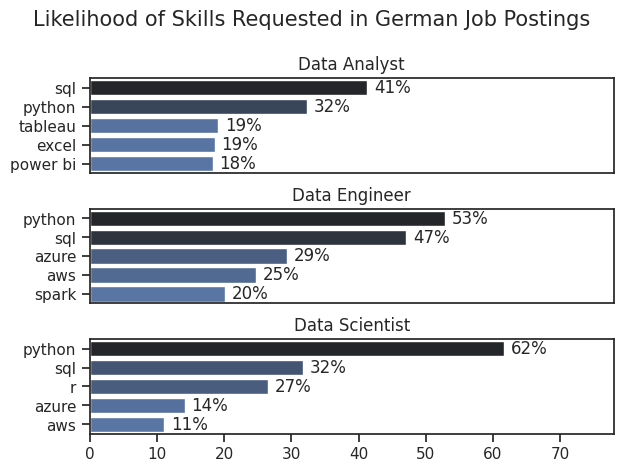

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in German Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()